In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [3]:
from preprocess import divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [4]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                
                try:
                    with open(cur_text_path, encoding="utf-16") as file:
                
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                
                            number_used_files += 1            
                except:
                    print("PROBLEM WITH FILE", cur_text_path)
                
    return file_texts, targets


In [5]:
CATEGORIES_COUNT = 2

In [8]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/France_New/Texts",
                                         images_directory="D:/svruchtel/DATA/France_New_ByMeaningLarge", 
                                         target_names = ["AllTransport", "Restaurant"])

Wall time: 1.17 s


In [9]:
text_1 = file_texts[0]
print(text_1)

RCOS ETOILE
53. AVENUE DE LA GRANDE ARMEE
75116 PARIS
TEL: 0145004023
FAX: 0145004029--
E-MAIL : f dsp6wnge.fr HERARD JEROME
REG: 49841888800018 82 RUE XAVIER DE MAISTRE
TVA: FR 27498 418 888
ca*talde**j* 92500 RUEIL MALMAISON
I FACTURE I WCUENT | OPERATEUR DATE PAGÊ"
I 4014331 I 8396 | 1 DANIELLE DARCOS 19/05/2017 1
REFERENCE| DESKNAT1QN QUANTITE PRD( UNTTT.T.C. MONTANTTTC T.VA.%
tOC SWING AG-903-EG 2DCJF****** 1,00 1000,004 1000.00 € 20,00
DU 1*60017 N11*10017
600 nfi INUQ 43K IMS SUPPiaenARE
FARE LES t*ÆAUX CHEZ DARCOS
TOUS LES 500 KMSMUQ
FORFAIT ASSISTANCE FORFAIT 1 DEPANNAGE PARS 1,00 30,00 € 30,00 € 20.00
TAUX BASE HT. MONTANT T VA ~l BRUT TTC. 1030,00 €
20.00 858,334 171.674
NET HT. 858.334
TOTAL T.VA 171.674
___ NETT.T.C. 1030,004
RESTE A PAYER__0,00 4
B—67 |C*n**NCM* I 1WW<
MERCI DE VOTRE VISITE
A BIENTOT
r~imî‘TiniiB gniim n�i>iTfr ~—r—i—*---"rr--—• * "•■•••-n t-----



In [10]:
#print(list(text_1))

text_new = [char for char in list(text_1) if (char != ' ' and char != '\n')]
print(text_new)


['R', 'C', 'O', 'S', 'E', 'T', 'O', 'I', 'L', 'E', '5', '3', '.', 'A', 'V', 'E', 'N', 'U', 'E', 'D', 'E', 'L', 'A', 'G', 'R', 'A', 'N', 'D', 'E', 'A', 'R', 'M', 'E', 'E', '7', '5', '1', '1', '6', 'P', 'A', 'R', 'I', 'S', 'T', 'E', 'L', ':', '0', '1', '4', '5', '0', '0', '4', '0', '2', '3', 'F', 'A', 'X', ':', '0', '1', '4', '5', '0', '0', '4', '0', '2', '9', '-', '-', 'E', '-', 'M', 'A', 'I', 'L', ':', 'f', 'd', 's', 'p', '6', 'w', 'n', 'g', 'e', '.', 'f', 'r', 'H', 'E', 'R', 'A', 'R', 'D', 'J', 'E', 'R', 'O', 'M', 'E', 'R', 'E', 'G', ':', '4', '9', '8', '4', '1', '8', '8', '8', '8', '0', '0', '0', '1', '8', '8', '2', 'R', 'U', 'E', 'X', 'A', 'V', 'I', 'E', 'R', 'D', 'E', 'M', 'A', 'I', 'S', 'T', 'R', 'E', 'T', 'V', 'A', ':', 'F', 'R', '2', '7', '4', '9', '8', '4', '1', '8', '8', '8', '8', 'c', 'a', '*', 't', 'a', 'l', 'd', 'e', '*', '*', 'j', '*', '9', '2', '5', '0', '0', 'R', 'U', 'E', 'I', 'L', 'M', 'A', 'L', 'M', 'A', 'I', 'S', 'O', 'N', 'I', 'F', 'A', 'C', 'T', 'U', 'R', 'E', 'I',

In [11]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [12]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d-char-fr.txt", 
                                    max_embeddings_count=300000)

ERROR! Shape is (299,) 0.37558
Wall time: 55.1 ms


In [13]:
print(emb_char_id_to_vector[0][:7])
print(emb_char_id_to_vector[1][:7])
print(emb_char_id_to_vector[112][:7])

[-0.5144   0.68382  0.65442 -0.18825 -0.10498 -0.83316 -0.224  ]
[ 0.159886 -0.617507 -0.032783  0.1499   -0.26142  -0.240116  0.228819]
[ 0.053742 -0.460417  0.103149  0.107124 -0.206126  0.022789  0.028764]


In [14]:
char_to_id['0']

49

In [15]:
def change_texts_to_lists_of_character_embeddings(X, emb_char_id_to_vector, char_to_id, characters_count=3000):
    """
    X - list of strings (original texts)
    """
    
    X_emb = []
    for text in X:
        text_chars = [char for char in list(text) if (char != ' ' and char != '\n')]
        
        embedded_text = []
        current_chars_count = 0
        
        for char in text_chars:
            if current_chars_count < characters_count:
                if char in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char]])
                    current_chars_count += 1
                elif char.lower() in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char.lower()]])
                    current_chars_count += 1
                else:
                    print("There is no embedding to char:", char)
        
        # if text is less long than need to be
        while current_chars_count < characters_count:
            embedded_text.append(emb_char_id_to_vector[char_to_id['0']])
            current_chars_count += 1    
        
        X_emb.append(np.array(embedded_text))
        
    return np.array(X_emb)

In [16]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

There is no embedding to char: ■
There is no embedding to char: —
There is no embedding to char: —
There is no embedding to char: —
There is no embedding to char: €
There is no embedding to char: €
There is no embedding to char: —
There is no embedding to char: ■
There is no embedding to char: ■
There is no embedding to char: •
There is no embedding to char: •
There is no embedding to char: ♦
There is no embedding to char: �
There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: •
There is no embedding to char: �
There is no embedding to char: •
There is no embedding to char: ■
There is no embedding to char: ■
There is no embedding to char: ■
There is no embedding to char: ■
There is no embedding to char: ‘
There is no embedding to char: ■
There is no embedding to char: �
There is no embedding to char: —
There is no embedding to char: —
There is no embedding to char: —
There is no embedding to char: —
There is no embedding to char: „
There is n

In [17]:
char_to_id['f']

14

In [18]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [19]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(2977, 100, 300)
(332, 100, 300)
(2977, 2)
(332, 2)


### 1

In [20]:
%%time

categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dense(CATEGORIES_COUNT, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Val accuracy: %.4f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 19s 6ms/step - loss: 0.6814 - acc: 0.5637 - val_loss: 0.6817 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 17s 6ms/step - loss: 0.6717 - acc: 0.5768 - val_loss: 0.6637 - val_acc: 0.5813
Epoch 3/200
2977/2977 [==============================] - 17s 6ms/step - loss: 0.6149 - acc: 0.6302 - val_loss: 0.6718 - val_acc: 0.6084
Epoch 4/200
2977/2977 [==============================] - 17s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1543  186]
 [ 199 1049]]
Normalized confusion matrix
[[0.89242337 0.10757663]
 [0.15945513 0.84054487]]


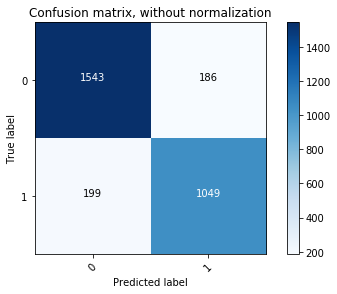

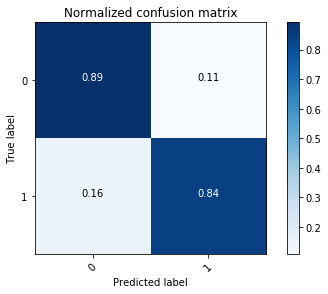

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[155  38]
 [ 33 106]]
Normalized confusion matrix
[[0.80310881 0.19689119]
 [0.23741007 0.76258993]]


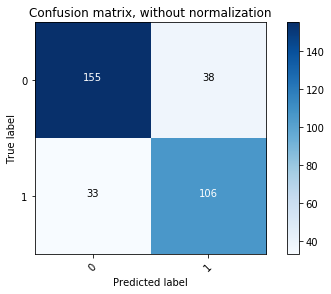

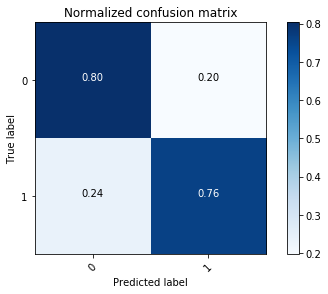

In [21]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7861


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_1st_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_1st_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByMeaning_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByMeaning_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 14.3 s


### 2

In [24]:
%%time
# Lets try one another architecture

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 20s 7ms/step - loss: 0.6902 - acc: 0.5576 - val_loss: 0.6764 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 18s 6ms/step - loss: 0.6758 - acc: 0.5768 - val_loss: 0.6843 - val_acc: 0.5723
Epoch 3/200
2977/2977 [==============================] - 18s 6ms/step - loss

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1640   89]
 [ 164 1084]]
Normalized confusion matrix
[[0.94852516 0.05147484]
 [0.13141026 0.86858974]]


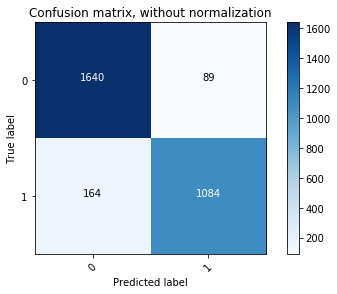

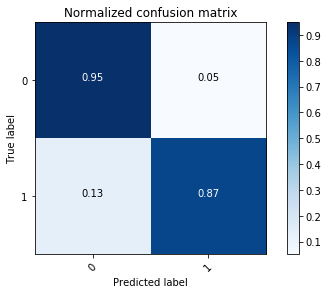

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[156  37]
 [ 32 107]]
Normalized confusion matrix
[[0.80829016 0.19170984]
 [0.23021583 0.76978417]]


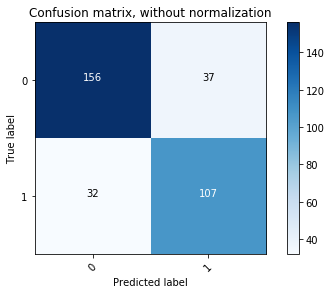

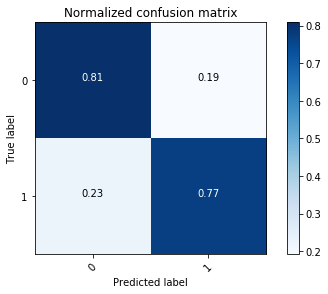

In [25]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [26]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7922


In [27]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_2nd_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_2nd_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"
1
np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 14.7 s


### 3

In [28]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 160,602
Trainable params: 160,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 21s 7ms/step - loss: 0.6834 - acc: 0.5707 - val_loss: 0.6777 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 19s 6ms/step - loss: 0.6721 - acc: 0.5643 - val_loss: 0.6707 - val_acc: 0.5301
Epoch 3/200
2977/2977 [==============================] - 19s 6ms/step - loss: 0.6479 - acc: 0.6040 - val_loss: 0.6776 - val_acc: 0.5964
Epoch 4/200
2977/2977 [==============================] - 19s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1514  215]
 [ 103 1145]]
Normalized confusion matrix
[[0.87565067 0.12434933]
 [0.08253205 0.91746795]]


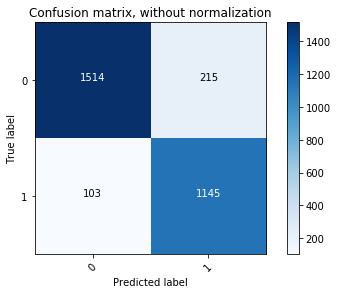

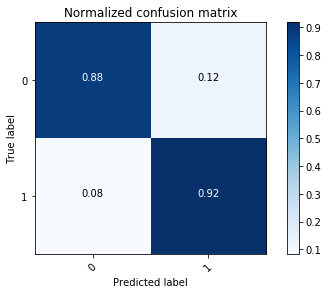

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[148  45]
 [ 22 117]]
Normalized confusion matrix
[[0.76683938 0.23316062]
 [0.15827338 0.84172662]]


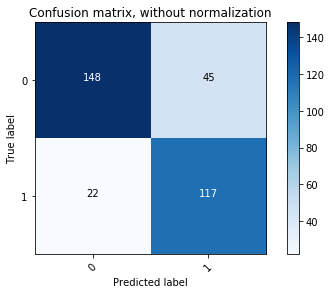

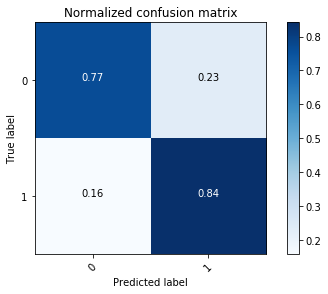

In [29]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [30]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7982


In [31]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_3rd_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_3rd_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 15.3 s


### 4

In [32]:
%%time
# and two LSTM's

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 401,602
Trainable params: 401,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200
2977/2977 [==============================] - 44s 15ms/step - loss: 0.6846 - acc: 0.5623 - val_loss: 0.6801 - val_acc: 0.5813
Epoch 2/200
2977/2977 [==============================] - 37s 12ms/step - loss: 0.6633 - acc: 0.5768 - val_loss: 0.6694 - val_acc: 0.5331
Epoch 3/200
2977/2977 [==============================] - 38s 13ms/step - l

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1449  280]
 [ 102 1146]]
Normalized confusion matrix
[[0.83805668 0.16194332]
 [0.08173077 0.91826923]]


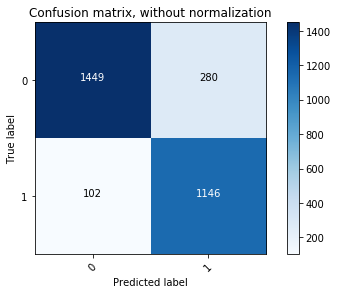

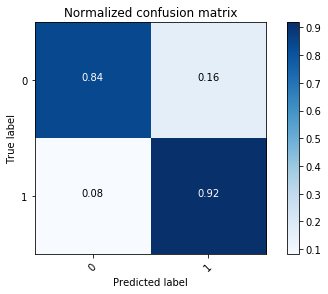

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[128  65]
 [ 23 116]]
Normalized confusion matrix
[[0.66321244 0.33678756]
 [0.16546763 0.83453237]]


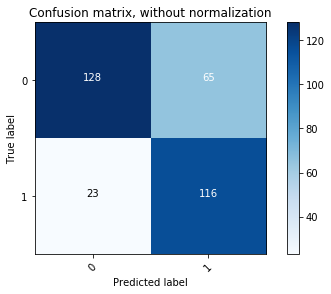

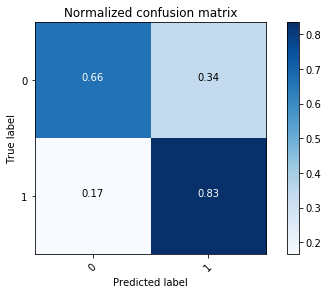

In [33]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [34]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7349


In [35]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_4th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_4th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 29.1 s


In [36]:
# Stay here

### 5

In [ ]:
%%time
# and also with 1d-convolutional layer

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 82,234
Trainable params: 82,234
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/200


TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 147    2    9  138    4    3    6]
 [   3   52    8   72    6    6    6]
 [  11    6  146   62    7    0    4]
 [  16    7   15 1161    9   28   12]
 [   2    4   16   59  150    5    9]
 [   6    0    3   74    2  641    6]
 [   3    3   31   79    7    9   68]]
Normalized confusion matrix
[[0.47572816 0.00647249 0.02912621 0.44660194 0.01294498 0.00970874
  0.01941748]
 [0.01960784 0.33986928 0.05228758 0.47058824 0.03921569 0.03921569
  0.03921569]
 [0.04661017 0.02542373 0.61864407 0.26271186 0.02966102 0.
  0.01694915]
 [0.01282051 0.00560897 0.01201923 0.93028846 0.00721154 0.0224359
  0.00961538]
 [0.00816327 0.01632653 0.06530612 0.24081633 0.6122449  0.02040816
  0.03673469]
 [0.00819672 0.         0.00409836 0.1010929  0.00273224 0.87568306
  0.00819672]
 [0.015      0.015      0.155      0.395      0.035      0.045
  0.34      ]]


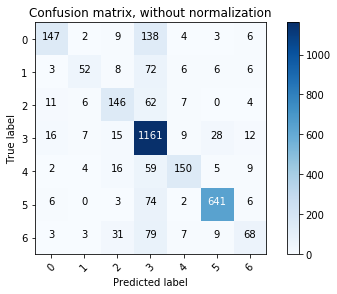

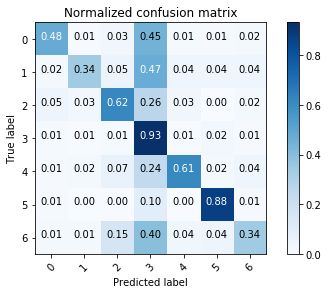

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 14   0   2  15   1   2   1]
 [  0   2   4   9   0   2   1]
 [  0   0  19   6   0   0   2]
 [  5   0   1 124   3   5   1]
 [  0   2   0  14  11   0   1]
 [  0   0   0   9   0  73   0]
 [  2   0   9   6   0   1   5]]
Normalized confusion matrix
[[0.4        0.         0.05714286 0.42857143 0.02857143 0.05714286
  0.02857143]
 [0.         0.11111111 0.22222222 0.5        0.         0.11111111
  0.05555556]
 [0.         0.         0.7037037  0.22222222 0.         0.
  0.07407407]
 [0.03597122 0.         0.00719424 0.89208633 0.02158273 0.03597122
  0.00719424]
 [0.         0.07142857 0.         0.5        0.39285714 0.
  0.03571429]
 [0.         0.         0.         0.1097561  0.         0.8902439
  0.        ]
 [0.08695652 0.         0.39130435 0.26086957 0.         0.04347826
  0.2173913 ]]


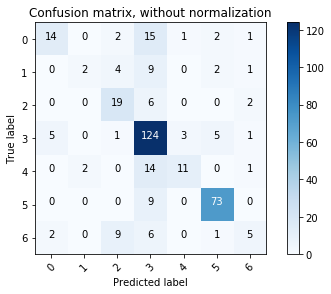

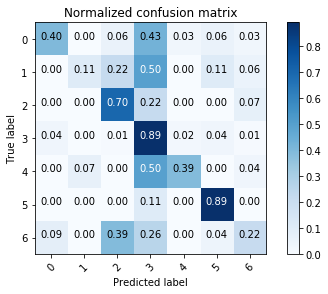

In [21]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [22]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7045


In [23]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_5th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_5th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 12 s


### 6

In [24]:
%%time

# create the model
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(Conv1D(input_shape=X_emb_train[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=20, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 100, 32)           28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 82,739
Trainable params: 82,739
Non-trainable params: 0
_________________________________________________________________
None
Train on 3123 samples, validate on 352 samples
Epoch 1/200
3123/3123 [==============================] - 71s 23ms/step - loss: 1.5380 - acc: 0.4701 - val_loss: 1.3836 - val_acc: 0.5483
Epoch 2/200
3123/3123 [==============================] - 67s 22ms/step - loss: 1.

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 230    1    7   49    3    7   12]
 [   0   92    8   32    2   13    6]
 [   5    4  185   22    4    7    9]
 [  12   14   24 1136    6   45   11]
 [   3    7   19   15  191    5    5]
 [   3    1    3   34    3  679    9]
 [   7    5   22   35    4    9  118]]
Normalized confusion matrix
[[0.74433657 0.00323625 0.02265372 0.15857605 0.00970874 0.02265372
  0.03883495]
 [0.         0.60130719 0.05228758 0.20915033 0.0130719  0.08496732
  0.03921569]
 [0.02118644 0.01694915 0.78389831 0.09322034 0.01694915 0.02966102
  0.03813559]
 [0.00961538 0.01121795 0.01923077 0.91025641 0.00480769 0.03605769
  0.0088141 ]
 [0.0122449  0.02857143 0.07755102 0.06122449 0.77959184 0.02040816
  0.02040816]
 [0.00409836 0.00136612 0.00409836 0.04644809 0.00409836 0.92759563
  0.01229508]
 [0.035      0.025      0.11       0.175      0.02       0.045
  0.59      ]]


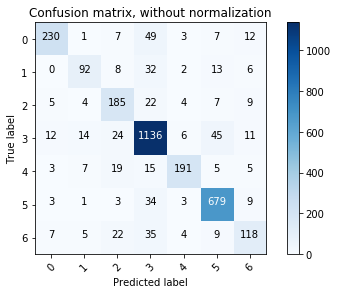

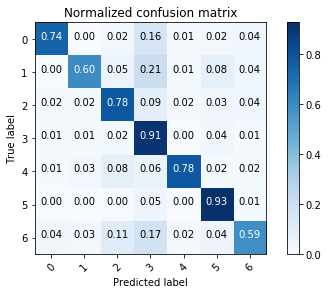

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 22   0   4   8   1   0   0]
 [  1   5   2   7   1   1   1]
 [  0   1  20   3   1   0   2]
 [  6   0   7 118   2   5   1]
 [  0   1   0  14  10   3   0]
 [  1   0   2   7   0  72   0]
 [  1   0  13   2   2   0   5]]
Normalized confusion matrix
[[0.62857143 0.         0.11428571 0.22857143 0.02857143 0.
  0.        ]
 [0.05555556 0.27777778 0.11111111 0.38888889 0.05555556 0.05555556
  0.05555556]
 [0.         0.03703704 0.74074074 0.11111111 0.03703704 0.
  0.07407407]
 [0.04316547 0.         0.05035971 0.84892086 0.01438849 0.03597122
  0.00719424]
 [0.         0.03571429 0.         0.5        0.35714286 0.10714286
  0.        ]
 [0.01219512 0.         0.02439024 0.08536585 0.         0.87804878
  0.        ]
 [0.04347826 0.         0.56521739 0.08695652 0.08695652 0.
  0.2173913 ]]


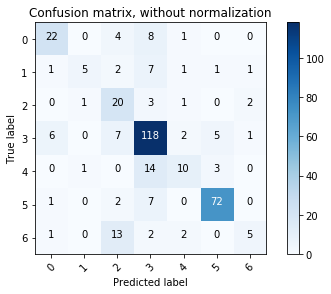

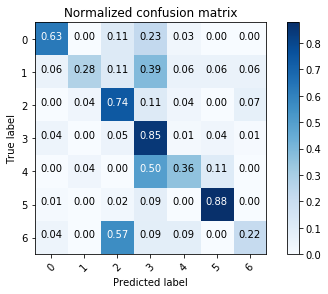

In [25]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [26]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.7159


In [27]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/France_ByMeaningLarge_6th_net_train_X_100_chars_GLOVE_FR.npy"
file_path_test_X = "./LSTM_results_char_emb/France_ByMeaningLarge_6th_net_test_X_100_chars_GLOVE_FR.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 13.3 s
